# Fine Tuning

El fine tuning de una red neuronal consiste en ajustar sus la salida de la red y sus parametros ya preentrenados con una base de datos mas pequeña y especifica que la utilizada para el entrenamiento de base.

Como realizar el finetuning depende del modelo elegido. A continuacion veremos como realizar finetuning de un modelo con arquitectura ViT (Vision Transformer) para clasificacion de imagenes y en las proximas unidades veremos como realizar finetuning de un modelo Transformer para clasificacion de texto.

## Fine Tuning de Modelos Transformers con Huggingface



!pip install datasets
https://github.com/huggingface/datasets
https://huggingface.co/datasets

Seleccionemos un dataset para clasificacion de imagenes:
- [Analisis de emociones 11MB](https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis)
- [Snaks 110MB](https://huggingface.co/datasets/Matthijs/snacks)
- [Flores 347MB](https://huggingface.co/datasets/nelorth/oxford-flowers)
- [RayosX Pulmones 203MB](https://huggingface.co/datasets/keremberke/chest-xray-classification)

In [8]:
from datasets import load_dataset
ds = load_dataset('FastJobs/Visual_Emotional_Analysis')
ds

Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
})

In [9]:
fila_ejemplo = ds['train'][0]
fila_ejemplo

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96>,
 'label': 0}

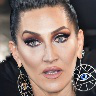

In [11]:
fila_ejemplo['image']

In [12]:
fila_ejemplo['label']

0

In [15]:
ds['train'].features['label']

ClassLabel(names=['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], id=None)

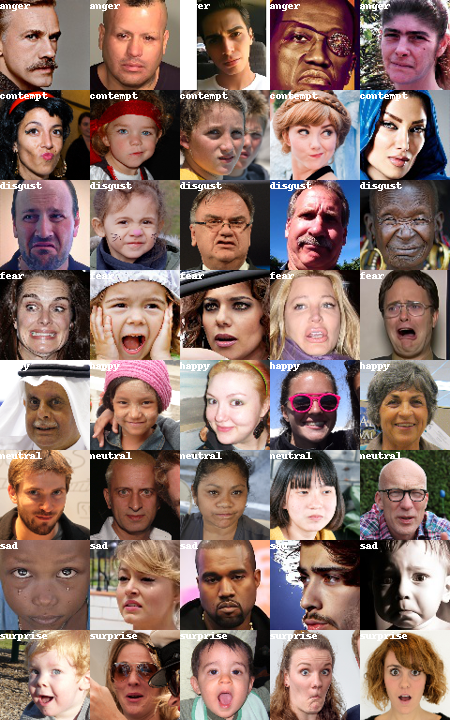

In [24]:
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed=42, examples_per_class=3, size=(90, 90)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255))

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=5)

## Convertir la imagen a la entrada que necesita el modelo

In [25]:
from transformers import ViTImageProcessor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

In [28]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['label']
    return inputs

In [29]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.2471, -0.2549, -0.2627,  ..., -0.6706, -0.6706, -0.6706],
          [-0.2471, -0.2549, -0.2627,  ..., -0.6706, -0.6706, -0.6706],
          [-0.2627, -0.2627, -0.2784,  ..., -0.6784, -0.6784, -0.6784],
          ...,
          [-0.8667, -0.8667, -0.8588,  ..., -0.8118, -0.8196, -0.8275],
          [-0.8745, -0.8745, -0.8667,  ..., -0.8196, -0.8353, -0.8431],
          [-0.8745, -0.8745, -0.8667,  ..., -0.8275, -0.8431, -0.8510]],

         [[-0.4588, -0.4588, -0.4667,  ..., -0.6392, -0.6392, -0.6392],
          [-0.4588, -0.4588, -0.4667,  ..., -0.6392, -0.6392, -0.6392],
          [-0.4588, -0.4588, -0.4667,  ..., -0.6471, -0.6471, -0.6471],
          ...,
          [-0.8431, -0.8431, -0.8353,  ..., -0.7804, -0.7882, -0.7961],
          [-0.8510, -0.8510, -0.8431,  ..., -0.7882, -0.8039, -0.8118],
          [-0.8510, -0.8510, -0.8431,  ..., -0.7961, -0.8118, -0.8196]],

         [[-0.5294, -0.5294, -0.5294,  ..., -0.5451, -0.5451, -0.5451],
          [-0

In [30]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [31]:
prepared_ds = ds.with_transform(transform)

## Create function to feed the model

In [32]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

## Load Evaluation Metric

In [33]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/var/folders/hx/lt8x1jn57x32723b5rfcjnmw0000gn/T/ipykernel_5087/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


## Load Model for Classification

In [34]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train Config

In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-emotions",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 from transformers import TrainingArguments                                                  │
│    2                                                                                             │
│ ❱  3 training_args = TrainingArguments(                                                          │
│    4   output_dir="./vit-emotions",                                                              │
│    5   per_device_train_batch_size=16,                                                           │
│    6   evaluation_strategy="steps",                                                              │
│ in __init__:114                                                                                  │
│                                                                                                  │
│ /Users/hernanamiune/opt/anaconda3/lib/python3.9/site-packages/transformers/training_args.py:1410 │
│ in __post_init__                                                                                 │
│                                                                                                  │
│   1407 │   │   │   and (get_xla_device_type(self.device) != "GPU")                               │
│   1408 │   │   │   and (self.fp16 or self.fp16_full_eval)                                        │
│   1409 │   │   ):                                                                                │
│ ❱ 1410 │   │   │   raise ValueError(                                                             │
│   1411 │   │   │   │   "FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half  │
│   1412 │   │   │   │   " (`--fp16_full_eval`) can only be used on CUDA or NPU devices."          │
│   1413 │   │   │   )                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation 
(`--fp16_full_eval`) can only be used on CUDA or NPU devices.

## Create Trainer

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=processor,
)

## Train

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

## Evaluate

In [ ]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Fin: [Volver al contenido del curso](https://www.freecodingtour.com/cursos/espanol/deeplearning/deeplearning.html)